# Imports

In [18]:
import yfinance as yf, numpy as np, pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import math

# Data Collection

This code snippet processes financial data for multiple stock tickers, calculating various technical metrics and financial features, and prepares the data for further analysis. It includes tasks such as calculating the Relative Strength Index (RSI), volatilities, correlation with the SPY index, and SMA crosses. The data is divided into training and testing sets for future use.

In [19]:
smas = ((30, 100), (50, 200), (70, 300))
window = 250

tickers = ['LMT', 'SO', 'BAC', 'ABT', 'IBM', 'MCD', 'TMO', 'WFC', 'COST', 'TSLA', 'NFLX', 'BA', 'AMAT', 'UNH', 'EXC', 'T',
 'C', 'GD', 'SPG', 'INTU', 'AXP', 'GE', 'HD', 'CVX', 'DHR', 'LUV', 'TXN', 'LLY', 'SBUX', 'CVS', 'TGT', 'PEP',
 'GOOGL', 'HON', 'JPM', 'QCOM', 'CMCSA', 'VZ', 'FDX', 'PG', 'NEM', 'AAPL', 'LOW', 'DIS', 'SLB', 'PM', 'CSX',
 'KO', 'GS', 'MET', 'NSC', 'AMGN', 'MMM', 'META', 'JNJ', 'AMZN', 'INTC', 'V', 'NEE', 'WMT', 'CSCO', 'GM', 'COP',
 'CAT', 'ADBE', 'ORCL', 'CME', 'PFE', 'OXY', 'MA', 'MSFT', 'UPS', 'ADP', 'MS', 'CRM', 'UNP', 'MO', 'EMR', 'NVDA',
 'GILD', 'BMY', 'ABBV', 'NKE', 'XOM', 'MRK', 'MDLZ']

df = yf.download(tickers, start='2000-01-01',auto_adjust=True)
spy = yf.download('SPY', start='2000-01-01', auto_adjust=True)
vix = yf.download('^VIX', start='2000-01-01', auto_adjust=True)

dfs_train, dfs_test = [], []
for ticker in tickers:
    data = df['Close'][ticker].to_frame()
    data.columns = ['Close']
    dif = data['Close'].diff()
    RSI_CONS = 50
    win = pd.DataFrame(np.where(dif > 0, dif, 0))
    loss = pd.DataFrame(np.where(dif < 0, abs(dif), 0))
    ema_win = win.ewm(alpha=1/RSI_CONS).mean()
    ema_loss = loss.ewm(alpha=1/RSI_CONS).mean()
    rs = ema_win / ema_loss
    rsi = 100 - (100 / (1 + rs))
    rsi.index = data.index

    data['Close'].ffill(inplace=True) 
    data['pctChange'] = data['Close'].pct_change()

    data['fw'] = data['Close'].shift(-window)/data['Close']-1
    data[f'RSI_{RSI_CONS}'] = rsi/100
    v = data['pctChange'].rolling(50).std() * 50**0.5
    data[' volatility_zs'] = (v - v.rolling(50).mean()) / v.rolling(50).std()
    data[' volatility_vix'] = v / vix.Close
    data['vix'] = vix.Close

    spy_zs_slow = (spy.Close - spy.Close.rolling(80).mean()) / spy.Close.rolling(80).std()
    spy_zs_fast = (spy.Close - spy.Close.rolling(40).mean()) / spy.Close.rolling(40).std()

    data['SP500_Zscore_fast'] = spy_zs_fast
    data['SP500_Zscore_slow'] = spy_zs_slow
    data['SP500_rel'] = spy_zs_slow / spy_zs_fast

    data['sma_volatility'] = data['pctChange'].rolling(50).std() * 50**0.5
    data['ema_volatility'] = data['pctChange'].ewm(span=40).std() * 40**0.5
    data['SPY_Corr'] = data.Close.pct_change().rolling(40).corr(spy.Close.pct_change())
    c1 = f'cross_{smas[0][0]}_{smas[0][1]}'
    c2 = f'cross_{smas[1][0]}_{smas[1][1]}'
    c3 = f'cross_{smas[2][0]}_{smas[2][1]}'
    data[c1] = data['Close'].rolling(smas[0][0]).mean()/data['Close'].rolling(smas[0][1]).mean()-1
    data[c2] = data['Close'].rolling(smas[1][0]).mean()/data['Close'].rolling(smas[1][1]).mean()-1
    data[c3] = data['Close'].rolling(smas[2][0]).mean()/data['Close'].rolling(smas[2][1]).mean()-1
    qtrain = int(len(data)*0.85)
    dfs_train.append(data.reset_index(drop=True).iloc[:qtrain])
    dfs_test.append(data.reset_index(drop=True).iloc[qtrain:])

data_train = pd.concat(dfs_train).reset_index(drop=True)
data_test = pd.concat(dfs_test).reset_index(drop=True)
len(data_train.dropna()), len(data_test.dropna())

[*********************100%%**********************]  86 of 86 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(389890, 55728)

# Design Matrix

This code snippet continues the data preparation by creating a target variable based on forward returns and separates features and labels. It labels a positive event if the forward return is greater than or equal to 0.14, preparing the data for binary classification tasks in machine learning.

In [20]:
data_train['target'] = 0
data_train.loc[data_train.fw >= 0.14 , 'target'] = 1
data_train.dropna(inplace=True)

data_test['target'] = 0
data_test.loc[data_test.fw >= 0.14 , 'target'] = 1

data_test_full = data_test.copy()
data_test.dropna(inplace=True)

features = 13
X_train, X_test = data_train.iloc[:,-(features+1):-1], data_test.iloc[:,-(features+1):-1]
y_train, y_test = data_train.iloc[:,-1], data_test.iloc[:,-1]

In [21]:
y_train.to_frame().groupby('target').size()

target
0    203563
1    186327
dtype: int64

# Fit and Test

CPU times: total: 125 ms
Wall time: 10.7 s


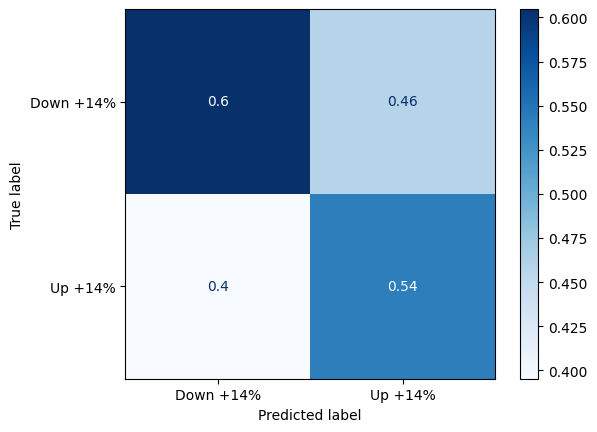

In [22]:
%%time

# Each node have at least 30 data
levels = int(math.log((len(X_train)/30),2))

model = DecisionTreeClassifier(criterion = 'entropy', max_depth=levels, random_state=1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

disp = ConfusionMatrixDisplay.from_estimator(model, X_test.dropna(), y_test.dropna(), normalize='pred',
                                             display_labels=['Down +14%','Up +14%'], cmap='Blues')

m = disp.confusion_matrix

## We analyze different targets that +14%

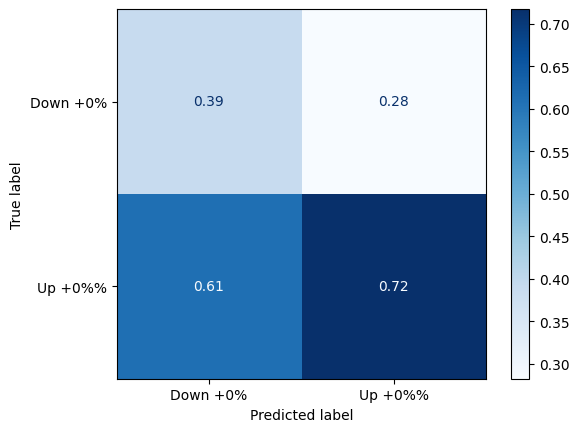

In [23]:
NEW_TARGET = 0.0

data_test_alt = data_test.copy()
data_test_alt['target'] = 0
data_test_alt.loc[data_test_alt.fw >= NEW_TARGET , 'target'] = 1
y_test_alt =  data_test_alt.iloc[:,-1]

# Since the trained model is the same, I only evaluate with the different criteria from the target
disp = ConfusionMatrixDisplay.from_estimator(model, X_test.dropna(), y_test_alt.dropna(), normalize='pred',
                                             display_labels=[f'Down +{NEW_TARGET:.0%}',f'Up +{NEW_TARGET:.0%}%'],
                                             cmap='Blues')


m = disp.confusion_matrix

In [24]:
data_test.quantile(0.28).fw

-0.044692336142777095

In [25]:
data_test.fw.median()

0.10671577936492904

# Calculation proxy Mathematical hope

In [26]:
data_test.fw.median()

0.10671577936492904

In [27]:
# Average of winning and losing trades (up +11%, down -11%)
w_mean = math.log(data_test.loc[data_test.fw>0.11].fw.mean() +1)
l_mean = math.log(data_test.loc[data_test.fw<-0.11].fw.mean() +1)

w_mean, l_mean

(0.36705303460115013, -0.28605267299772225)

In [28]:
# % of positive trades (above +14%) and negative trades (below -14%)
# Recalculate the validation values ​​based on the target
def getTestAlt(TARGET):
    data_test_alt = data_test.copy()
    data_test_alt['target'] = 0
    data_test_alt.loc[data_test_alt.fw >= TARGET , 'target'] = 1
    y_test_alt =  data_test_alt.iloc[:,-1]
    return y_test_alt

# I use the confusion matrix to calculate the probability of hitting or missing
m_up_11 = np.array(confusion_matrix(getTestAlt(0.14), y_pred, normalize='pred'))
win_q = m_up_11[1][1]

m_down_11 = np.array(confusion_matrix(getTestAlt(-0.14), y_pred, normalize='pred'))
loss_q = m_down_11[0][1]

win_q, loss_q

(0.5409597880432461, 0.13858382120422205)

In [29]:
# I normalize the probabilities to 100%
# I am discarding all trades between -14% and 14% because I assume they offset each other
win_perc, loss_perc = win_q/(win_q+loss_q), loss_q/(win_q+loss_q)
win_perc, loss_perc

(0.7960633882530499, 0.20393661174695005)

In [30]:
# Mathematical mean
E = math.e** (w_mean * win_perc + l_mean * loss_perc) - 1
E

0.26346869292335184